/Users/pedrof/miniconda3/envs/py310/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/pedrof/miniconda3/envs/py310/lib/python3.10/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/pedrof/miniconda3/envs/py310/lib/python3.10/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


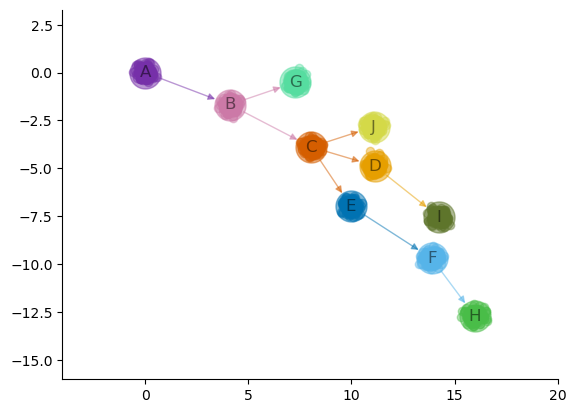

In [1]:
import scatrex
import matplotlib.pyplot as plt
import numpy as np

seed = 12345

# Create SCATrEx object for the simulation
sim_sca = scatrex.SCATrEx(model=scatrex.models.TrajectoryTree, 
                          model_args={'obs_variance':0.2,
                                      'event_mean':2.,
                                      'event_concentration':100.,
                                     'angle_concentration':5.,
                                     'loc_variance':.1,
                                     'root_event_mean':10.,
                                     'n_factors': 0,
                                     'obs_weight_variance':1.,
                                     'factor_variance':.1},
                          seed=seed) # Use the Trajectory model here for simplicity

# Simulate an observed tree with 10 nodes
full_observed_tree = scatrex.models.TrajectoryTree(**{'n_nodes':10, 'seed':1234,
                                                      'add_root': False})
full_observed_tree.generate_tree()
full_observed_tree.add_node_params(n_genes=2,min_dist=0.5, **{'event_mean': 4.,
                                                              'event_concentration':100.,
                                            'angle_concentration': 2.,
                                            'loc_variance': .1})

# Simulate data from this tree without any extra nodes
sim_sca.simulate_tree(observed_tree=full_observed_tree, 
                      n_extra_per_observed=0,)

# Simulate data from the tree
sim_sca.simulate_data(n_cells=3000)

# Inspect the SCATrEx object
print(sim_sca)

# See the tree and data
sim_sca.plot_data(draw=False, alpha=0.4, remove_noise=True)
ax = plt.gca()
sim_sca.plot_tree_projection(level=1, ax=ax, node_size=500)

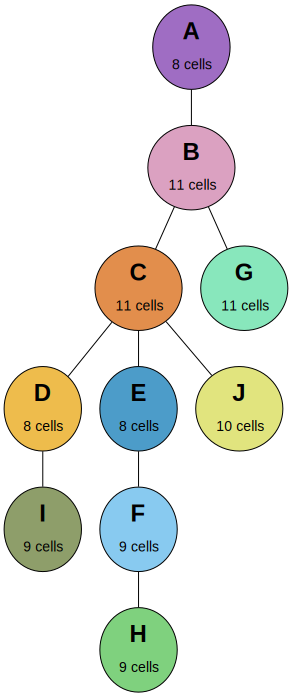

In [2]:
full_observed_tree.plot_tree()

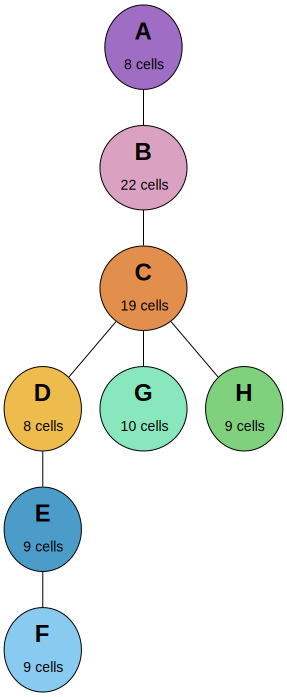

In [3]:
full_observed_tree.seed = 1
observed_tree = full_observed_tree.subsample(keep_prob=0.8, force=True)
observed_tree.plot_tree()
observed_tree.change_names()
observed_tree.set_colors(root_node='root')
observed_tree.plot_tree()

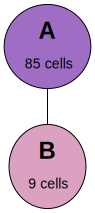

In [4]:
full_observed_tree.seed = 14
observed_tree = full_observed_tree.subsample(keep_prob=.2, force=False)
observed_tree.change_names()
observed_tree.set_colors(root_node='root')
observed_tree.plot_tree()

In [5]:
from scatrex.ntssb import NTSSB

sca = scatrex.SCATrEx(model=scatrex.models.TrajectoryTree, 
                          model_args={'obs_variance':.2,
                                      'event_mean':4.,
                                      'event_concentration': 1.,
                                     'angle_concentration':5.,
                                     'loc_variance':.1,
                                     'root_event_mean':4.,
                                     'n_factors': 0,
                                     'obs_weight_variance':1.,
                                     'factor_variance':.1},
                          seed=12) # Use the Trajectory model here for simplicity
sca.add_data(np.array(sim_sca.ntssb.data))

sca.set_observed_tree(observed_tree)
sca.ntssb = NTSSB(
            sca.observed_tree, node_hyperparams=sca.model_args, seed=2,
            use_weights=True,
            weights_concentration=1e3
        )
sca.ntssb.set_pivot_priors()
sca.ntssb.add_data(
    np.array(sim_sca.ntssb.data)
)
sca.ntssb.make_batches(None, 42)
sca.ntssb.reset_variational_parameters()
sca.ntssb.sample_variational_distributions(n_samples=100)

/Users/pedrof/miniconda3/envs/py310/lib/python3.10/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/pedrof/miniconda3/envs/py310/lib/python3.10/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


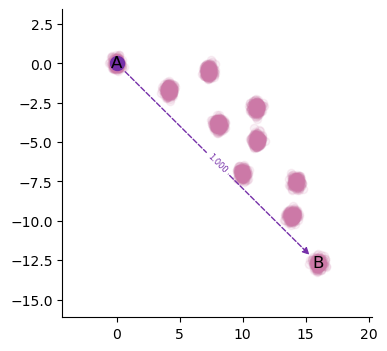

In [6]:
sca.ntssb.show_tree()
sca.plot_data(alpha=.1, zorder=-1)

In [7]:
from scatrex.ntssb import StructureSearch
from copy import deepcopy

searcher = StructureSearch(sca.ntssb)
searcher.tree.set_tssb_params(dp_alpha=1., dp_gamma=1.)
searcher.tree.sample_variational_distributions(n_samples=10)
searcher.tree.reset_sufficient_statistics()
for batch_idx in range(len(searcher.tree.batch_indices)):
    searcher.tree.update_sufficient_statistics(batch_idx=batch_idx)
searcher.tree.learn_params(50, update_roots=False, mc_samples=10, 
                                step_size=.1, memoized=True, update_outer_ass=True, ass_anneal=1.)    
searcher.tree.compute_elbo(memoized=True)
searcher.proposed_tree = deepcopy(searcher.tree) 
searcher.run_search(n_iters=20, n_epochs=20, mc_samples=10, step_size=.1, 
                        memoized=True, seed=4,
                        update_outer_ass=True,
                        update_roots=False,
                        moves_per_tssb=2,
                        pr_freq=0)
# searcher.run_search(n_iters=50, n_epochs=20, mc_samples=10, step_size=.1, 
#                         memoized=True, seed=4,
#                         update_outer_ass=True,
#                         update_roots=False,
#                         moves_per_tssb=3,
#                         pr_freq=1)
sca.ntssb = deepcopy(searcher.tree)

Finding NTSSB (10 nodes, elbo: -9852.60546875): 100%|██████████| 20/20 [03:58<00:00, 11.90s/it]  


In [8]:
searcher.tree.elbo

Array(-9852.605, dtype=float32)

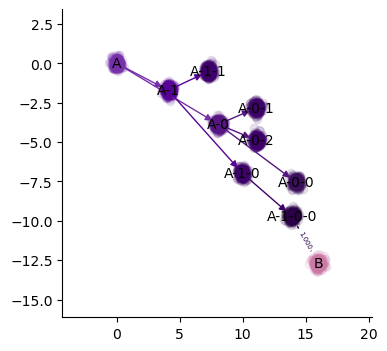

In [9]:
sca.ntssb = deepcopy(searcher.best_tree)
sca.ntssb.show_tree(edge_labels=True, font_size=10)
sca.plot_data(alpha=.1, zorder=-1)

In [10]:
searcher.run_mcmc(n_samples=500, n_burnin=50, n_thin=1, store_trees=False, memoized=True, n_opt_steps=50, step_size=0.1, seed=42)

MCMC for A: iteration: 499, acceptance ratio: 0.1202, best: -8769 (at 248): 100%|██████████| 500/500 [04:33<00:00,  1.83it/s]


In [13]:
probs = dict()
for node in searcher.mcmc:
    if 'posterior_freqs' in searcher.mcmc[node]:
        probs[node] = searcher.mcmc[node]['posterior_freqs']
    else:
        probs[node] = searcher.mcmc[node]['posterior_counts']
probs['A']

,A,A-0,A-2,A-0-0,A-0-0-0,A-1,A-2-0,A-1-0,A-1-0-0
A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A-0,1.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,0.000000,0.0
A-2,0.837416,0.162584,0.000000,0.00000,0.0,0.000000,0.000000,0.000000,0.0
A-0-0,0.000000,0.610245,0.000000,0.00000,0.0,0.389755,0.000000,0.000000,0.0
A-0-0-0,0.000000,0.000000,0.000000,1.00000,0.0,0.000000,0.000000,0.000000,0.0
A-1,0.489978,0.510022,0.000000,0.00000,0.0,0.000000,0.000000,0.000000,0.0
A-2-0,0.026726,0.596882,0.371938,0.00000,0.0,0.004454,0.000000,0.000000,0.0
A-1-0,0.000000,0.000000,0.000000,0.00000,0.0,1.000000,0.000000,0.000000,0.0
A-1-0-0,0.000000,0.000000,0.000000,0.08686,0.0,0.367483,0.035635,0.510022,0.0


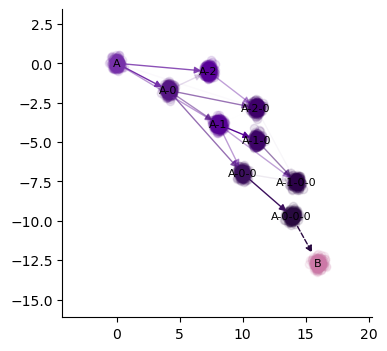

In [12]:
sca.ntssb = deepcopy(searcher.best_tree)
sca.ntssb.show_tree(labels=True, edge_labels=False, subtree_parent_probs=probs, font_size=8)
sca.plot_data(alpha=.1, zorder=-1)

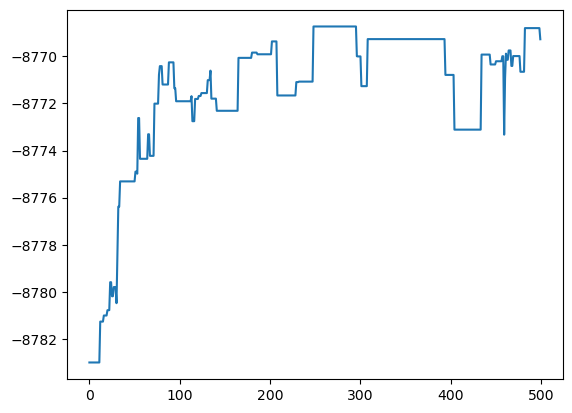

In [14]:
plt.plot(searcher.mcmc['A']['elbos'])

## Evaluate

In [ ]:
sca.ntssb.assign_samples()

node_assignments = [
    sca.ntssb.root["node"].root["node"].label
] * sca.adata.shape[0]
for i, idx in enumerate(range(3000)):
    node_assignments[idx] = sca.ntssb.assignments[i].label

true_assignments = [
    sim_sca.ntssb.root["node"].root["node"].label
] * sim_sca.adata.shape[0]
for i, idx in enumerate(range(3000)):
    true_assignments[idx] = sim_sca.ntssb.assignments[i].label    

true_labels = np.unique(true_assignments)
inf_labels = np.unique(node_assignments)
mat = []
for tr in true_labels:
    inmat = []
    tr_cells = set(np.where(np.array(true_assignments) == tr)[0])
    for inf in inf_labels:
        inf_cells = set(np.where(np.array(node_assignments) == inf)[0])
        inmat.append(len(set(tr_cells).intersection(set(inf_cells))))

    mat.append(inmat)

import pandas as pd
pd.DataFrame(np.array(mat), index=true_labels, columns=inf_labels)

,A,B,B-0,B-1-0,C,C-0,C-0-0,D,E,E-0
A,238,0,0,0,0,0,0,0,0,0
B,0,353,0,0,0,0,0,0,0,0
C,0,0,0,0,365,0,0,0,0,0
D,0,0,0,0,0,297,0,0,0,0
E,0,0,0,243,0,0,0,0,0,0
F,0,0,0,0,0,0,0,0,294,0
G,0,0,353,0,0,0,0,0,0,0
H,0,0,0,0,0,0,0,0,0,281
I,0,0,0,0,0,0,275,0,0,0
J,0,0,0,0,0,0,0,301,0,0


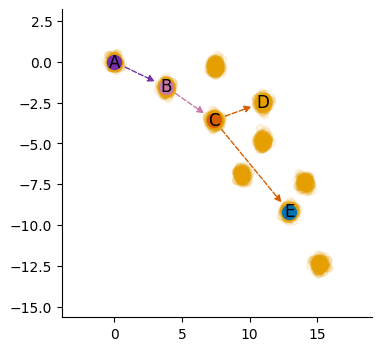

In [ ]:
import jax
for i in range(5):
    searcher.merge(jax.random.PRNGKey(0+i))
sca.ntssb = deepcopy(searcher.tree)
sca.ntssb.show_tree()
sca.plot_data(alpha=.1, zorder=-1)

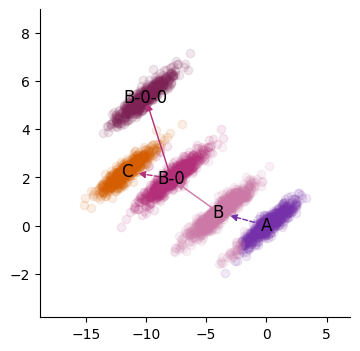

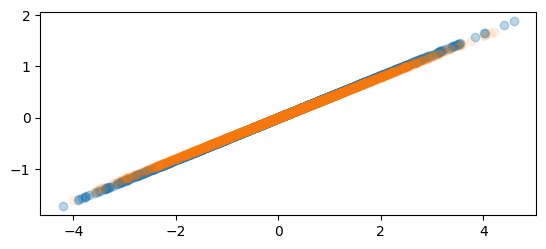

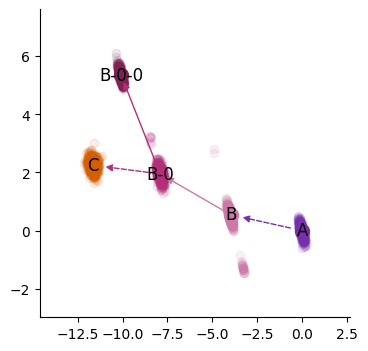

In [ ]:
# Weird! What is B-1 in doing there? It improves the ELBO somehow?!

searcher.proposed_tree.root['node'].root['node'].set_learned_parameters()

sca.ntssb = searcher.proposed_tree
searcher.proposed_tree.show_tree()
sca.plot_data(alpha=.1, zorder=-1, remove_noise=False)
